In [40]:
import numpy as np
import pandas as pd
import itertools
import os
import glob 
from astropy.stats import sigma_clip

from tqdm import tqdm

In [41]:
path_folder = './input/ariel-data-challenge-2024/' # path to the folder containing the data
path_out = './output/tmp/data_light_raw/' # path to the folder to store the light data
output_dir = './output/tmp/data_light_raw/' # path for the output directory

In [43]:
if not os.path.exists(path_out):
    os.makedirs(path_out)
    print(f"Directory {path_out} created.")
else:
    print(f"Directory {path_out} already exists.")

Directory ./output/tmp/data_light_raw/ already exists.


In [23]:
CHUNKS_SIZE = 1


In [44]:
def ADC_convert(signal, gain, offset):
    signal = signal.astype(np.float64)
    signal /= gain
    signal += offset
    return signal

In [45]:
def mask_hot_dead(signal, dead, dark):
    hot = sigma_clip(
        dark, sigma=5, maxiters=5
    ).mask
    hot = np.tile(hot, (signal.shape[0], 1, 1))
    dead = np.tile(dead, (signal.shape[0], 1, 1))
    signal = np.ma.masked_where(dead, signal)
    signal = np.ma.masked_where(hot, signal)
    return signal

In [46]:
def apply_linear_corr(linear_corr,clean_signal):
    linear_corr = np.flip(linear_corr, axis=0)
    for x, y in itertools.product(
                range(clean_signal.shape[1]), range(clean_signal.shape[2])
            ):
        poli = np.poly1d(linear_corr[:, x, y])
        clean_signal[:, x, y] = poli(clean_signal[:, x, y])
    return clean_signal

In [47]:
def clean_dark(signal, dead, dark, dt):

    dark = np.ma.masked_where(dead, dark)
    dark = np.tile(dark, (signal.shape[0], 1, 1))

    signal -= dark* dt[:, np.newaxis, np.newaxis]
    return signal

In [50]:
def get_cds(signal):
    cds = signal[:,1::2,:,:] - signal[:,::2,:,:]
    return cds

In [49]:
def bin_obs(cds_signal,binning):
    cds_transposed = cds_signal.transpose(0,1,3,2)
    cds_binned = np.zeros((cds_transposed.shape[0], cds_transposed.shape[1]//binning, cds_transposed.shape[2], cds_transposed.shape[3]))
    for i in range(cds_transposed.shape[1]//binning):
        cds_binned[:,i,:,:] = np.sum(cds_transposed[:,i*binning:(i+1)*binning,:,:], axis=1)
    return cds_binned

In [51]:
def correct_flat_field(flat,dead, signal):
    flat = flat.transpose(1, 0)
    dead = dead.transpose(1, 0)
    flat = np.ma.masked_where(dead, flat)
    flat = np.tile(flat, (signal.shape[0], 1, 1))
    signal = signal / flat
    return signal

In [52]:
## we will start by getting the index of the training data:
def get_index(files,CHUNKS_SIZE ):
    index = []
    for file in files :
        file_name = file.split('/')[-1]
        if file_name.split('_')[0] == 'AIRS-CH0' and file_name.split('_')[1] == 'signal.parquet':
            file_index = os.path.basename(os.path.dirname(file))
            index.append(int(file_index))
    index = np.array(index)
    index = np.sort(index) 
    # credit to DennisSakva
    index=np.array_split(index, len(index)//CHUNKS_SIZE)
    
    return index

In [53]:
files = glob.glob(os.path.join(path_folder + 'train/', '*/*'))

index = get_index(files[:22],CHUNKS_SIZE)  ## 48 is hardcoded here but please feel free to remove it if you want to do it for the entire dataset

train_adc_info = pd.read_csv(os.path.join(path_folder, 'train_adc_info.csv'))
train_adc_info = train_adc_info.set_index('planet_id')
axis_info = pd.read_parquet(os.path.join(path_folder,'axis_info.parquet'))
DO_MASK = True
DO_THE_NL_CORR = False
DO_DARK = True
DO_FLAT = True
TIME_BINNING = True

cut_inf, cut_sup = 39, 321
l = cut_sup - cut_inf

for n, index_chunk in enumerate(tqdm(index)):
    AIRS_CH0_clean = np.zeros((CHUNKS_SIZE, 11250, 32, l))
    FGS1_clean = np.zeros((CHUNKS_SIZE, 135000, 32, 32))
    
    for i in range (CHUNKS_SIZE) : 
        df = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_signal.parquet'))
        signal = df.values.astype(np.float64).reshape((df.shape[0], 32, 356))
        gain = train_adc_info['AIRS-CH0_adc_gain'].loc[index_chunk[i]]
        offset = train_adc_info['AIRS-CH0_adc_offset'].loc[index_chunk[i]]
        signal = ADC_convert(signal, gain, offset)
        dt_airs = axis_info['AIRS-CH0-integration_time'].dropna().values
        dt_airs[1::2] += 0.1
        chopped_signal = signal[:, :, cut_inf:cut_sup]
        del signal, df
        
        # CLEANING THE DATA: AIRS
        flat = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration/flat.parquet')).values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]
        dark = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration/dark.parquet')).values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]
        dead_airs = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration/dead.parquet')).values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]
        linear_corr = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration/linear_corr.parquet')).values.astype(np.float64).reshape((6, 32, 356))[:, :, cut_inf:cut_sup]
        
        if DO_MASK:
            chopped_signal = mask_hot_dead(chopped_signal, dead_airs, dark)
            AIRS_CH0_clean[i] = chopped_signal
        else:
            AIRS_CH0_clean[i] = chopped_signal
            
        if DO_THE_NL_CORR: 
            linear_corr_signal = apply_linear_corr(linear_corr,AIRS_CH0_clean[i])
            AIRS_CH0_clean[i,:, :, :] = linear_corr_signal
        del linear_corr
        
        if DO_DARK: 
            cleaned_signal = clean_dark(AIRS_CH0_clean[i], dead_airs, dark, dt_airs)
            AIRS_CH0_clean[i] = cleaned_signal
        else: 
            pass
        del dark
        
        df = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_signal.parquet'))
        fgs_signal = df.values.astype(np.float64).reshape((df.shape[0], 32, 32))
        
        FGS1_gain = train_adc_info['FGS1_adc_gain'].loc[index_chunk[i]]
        FGS1_offset = train_adc_info['FGS1_adc_offset'].loc[index_chunk[i]]
        
        fgs_signal = ADC_convert(fgs_signal, FGS1_gain, FGS1_offset)
        dt_fgs1 = np.ones(len(fgs_signal))*0.1
        dt_fgs1[1::2] += 0.1
        chopped_FGS1 = fgs_signal
        del fgs_signal, df
        
        # CLEANING THE DATA: FGS1
        flat = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration/flat.parquet')).values.astype(np.float64).reshape((32, 32))
        dark = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration/dark.parquet')).values.astype(np.float64).reshape((32, 32))
        dead_fgs1 = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration/dead.parquet')).values.astype(np.float64).reshape((32, 32))
        linear_corr = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration/linear_corr.parquet')).values.astype(np.float64).reshape((6, 32, 32))
        
        if DO_MASK:
            chopped_FGS1 = mask_hot_dead(chopped_FGS1, dead_fgs1, dark)
            FGS1_clean[i] = chopped_FGS1
        else:
            FGS1_clean[i] = chopped_FGS1

        if DO_THE_NL_CORR: 
            linear_corr_signal = apply_linear_corr(linear_corr,FGS1_clean[i])
            FGS1_clean[i,:, :, :] = linear_corr_signal
        del linear_corr
        
        if DO_DARK: 
            cleaned_signal = clean_dark(FGS1_clean[i], dead_fgs1, dark,dt_fgs1)
            FGS1_clean[i] = cleaned_signal
        else: 
            pass
        del dark
        
    # SAVE DATA AND FREE SPACE
    AIRS_cds = get_cds(AIRS_CH0_clean)
    FGS1_cds = get_cds(FGS1_clean)
    
    del AIRS_CH0_clean, FGS1_clean
    
    ## (Optional) Time Binning to reduce space
    if TIME_BINNING:
        AIRS_cds_binned = bin_obs(AIRS_cds,binning=30)
        FGS1_cds_binned = bin_obs(FGS1_cds,binning=30*12)
    else:
        AIRS_cds = AIRS_cds.transpose(0,1,3,2) ## this is important to make it consistent for flat fielding, but you can always change it
        AIRS_cds_binned = AIRS_cds
        FGS1_cds = FGS1_cds.transpose(0,1,3,2)
        FGS1_cds_binned = FGS1_cds
    
    del AIRS_cds, FGS1_cds
    
    for i in range (CHUNKS_SIZE):
        flat_airs = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/AIRS-CH0_calibration/flat.parquet')).values.astype(np.float64).reshape((32, 356))[:, cut_inf:cut_sup]
        flat_fgs = pd.read_parquet(os.path.join(path_folder,f'train/{index_chunk[i]}/FGS1_calibration/flat.parquet')).values.astype(np.float64).reshape((32, 32))
        if DO_FLAT:
            corrected_AIRS_cds_binned = correct_flat_field(flat_airs,dead_airs, AIRS_cds_binned[i])
            AIRS_cds_binned[i] = corrected_AIRS_cds_binned
            corrected_FGS1_cds_binned = correct_flat_field(flat_fgs,dead_fgs1, FGS1_cds_binned[i])
            FGS1_cds_binned[i] = corrected_FGS1_cds_binned
        else:
            pass

    ## save data
    np.save(os.path.join(path_out, 'AIRS_clean_train_{}.npy'.format(n)), AIRS_cds_binned)
    np.save(os.path.join(path_out, 'FGS1_train_{}.npy'.format(n)), FGS1_cds_binned)
    del AIRS_cds_binned
    del FGS1_cds_binned

100%|██████████| 6/6 [00:27<00:00,  4.58s/it]


In [55]:
def load_data (file, chunk_size, nb_files) : 
    data0 = np.load(file + '_0.npy')
    data_all = np.zeros((nb_files*chunk_size, data0.shape[1], data0.shape[2], data0.shape[3]))
    data_all[:chunk_size] = data0
    for i in range (1, nb_files) : 
        data_all[i*chunk_size:(i+1)*chunk_size] = np.load(file + '_{}.npy'.format(i))
    return data_all 

data_train = load_data(path_out + 'AIRS_clean_train', CHUNKS_SIZE, len(index)) 
data_train_FGS = load_data(path_out + 'FGS1_train', CHUNKS_SIZE, len(index))

In [57]:
print(data_train.shape)

(6, 187, 282, 32)


In [58]:
np.save('./output/working/' + 'data_train.npy', data_train)
np.save('./output/working/' + 'data_train_FGS.npy', data_train_FGS)

In [59]:
import matplotlib.pyplot as plt 

print('Shape of the training datasset: \t')
print('\n For AIRS-CH0:', data_train.shape)
print('\n For FGS1:', data_train_FGS.shape)

Shape of the training datasset: 	

 For AIRS-CH0: (6, 187, 282, 32)

 For FGS1: (6, 187, 32, 32)


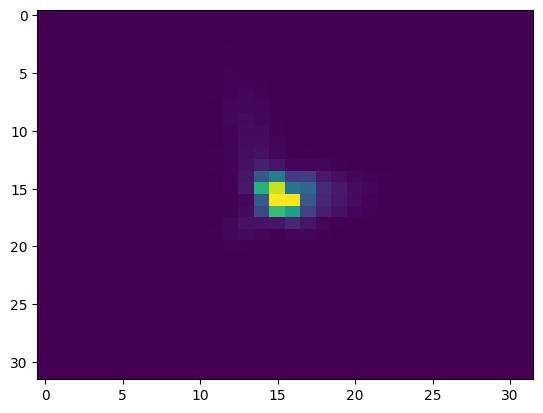

In [37]:
plt.imshow(data_train_FGS[-1,50,:,:].T, aspect = 'auto')


Text(0, 0.5, 'Normalized flux in the frame')

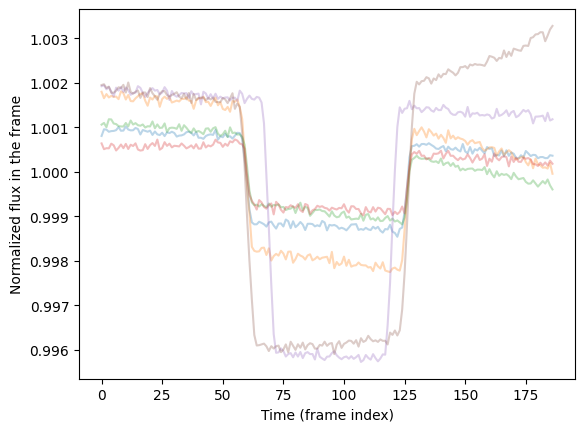

In [60]:
for i in range(len(data_train)) : 
    light_curve = data_train[i,:,:,:].sum(axis=(1,2))
    plt.plot(light_curve/light_curve.mean(), '-', alpha=0.3)

plt.xlabel('Time (frame index)')
plt.ylabel('Normalized flux in the frame')